In [ ]:
%pip install pandas_montecarlo --upgrade --no-cache-dir


For monthly, weekly and daily timeframes
- Establish that distribution is not normal
- Establish that *all* the value lies in the tail 
- Determine at what price are options cost effective (back testing) - pure barbell
- Determine at what price is insurance for a long only portfolio cost effective (back testing)
- Monte Carlo and bust probabilities 
- TODO
    - Capturing the 4th moment strategy 
    - Understand how to calculate alpha of the tail, use Hill estimator and more sophisticated stuff.

In [201]:
import pandas as pd
import numpy as np
import pandas_montecarlo

# Shiller monthly data

In [317]:
# From shiller 
df = pd.read_excel("ie_data.xls", "Data")


In [318]:
df[7:].head(20)

Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4   Unnamed: 5  \
7     1871.01       4.44       0.26        0.4  12.464061  1871.041667   
8     1871.02        4.5       0.26        0.4  12.844641     1871.125   
9     1871.03       4.61       0.26        0.4  13.034972  1871.208333   
10    1871.04       4.74       0.26        0.4  12.559226  1871.291667   
11    1871.05       4.86       0.26        0.4  12.273812     1871.375   
12    1871.06       4.82       0.26        0.4  12.083481  1871.458333   
13    1871.07       4.73       0.26        0.4  12.083481  1871.541667   
14    1871.08       4.79       0.26        0.4  11.893231     1871.625   
15    1871.09       4.84       0.26        0.4  12.178646  1871.708333   
16     1871.1       4.59       0.26        0.4  12.368896  1871.791667   
17    1871.11       4.64       0.26        0.4  12.368896     1871.875   
18    1871.12       4.74       0.26        0.4  12.654392  1871.958333   
19    1872.01       4.86     0.2633     0.4025  12.654392  1872.041667   
20    1872.02       4.88     0.2667      0.405  12.654392     1872.125   
21    1872.03       5.04       0.27     0.4075  12.844641  1872.208333   
22    1872.04       5.18     0.2733       0.41  13.130137  1872.291667   
23    1872.05       5.18     0.2767     0.4125  13.130137     1872.375   
24    1872.06       5.13       0.28      0.415  13.034972  1872.458333   
25    1872.07        5.1     0.2833     0.4175  12.844641  1872.541667   
26    1872.08       5.04     0.2867       0.42  12.939807     1872.625   

   Unnamed: 6  Unnamed: 7 Unnamed: 8  Unnamed: 9  ... Unnamed: 12 Unnamed: 13  \
7        5.32   97.250271   5.694836   97.250271  ...         NaN         NaN   
8    5.323333   95.644049   5.526101   96.104557  ...         NaN         NaN   
9    5.326667   96.551327   5.445411   97.472173  ...         NaN         NaN   
10       5.33  103.034548   5.651684  104.492692  ...         NaN         NaN   
11   5.333333  108.099637   5.783108  110.118209  ...         NaN         NaN   
12   5.336667  108.898625     5.8742  111.430773  ...         NaN         NaN   
13       5.34  106.865248     5.8742  109.851015  ...         NaN         NaN   
14   5.343333  109.951982   5.968166  113.535234  ...         NaN         NaN   
15   5.346667  108.496009   5.828298  112.533332  ...         NaN         NaN   
16       5.35  101.309267   5.738651  105.575174  ...         NaN         NaN   
17   5.353333  102.412853   5.738651  107.223588  ...         NaN         NaN   
18   5.356667  102.259693   5.609181  107.552623  ...         NaN         NaN   
19       5.36  104.848546   5.680375   110.77334  ...         NaN         NaN   
20   5.378333  105.280022   5.753726  111.735769  ...         NaN         NaN   
21   5.396667  107.121335   5.738643  114.197535  ...         NaN         NaN   
22      5.415  107.703029   5.682478  115.322475  ...         NaN         NaN   
23   5.433333  107.703029   5.753171  115.835823  ...         NaN         NaN   
24   5.451667  107.442149   5.864289  116.080837  ...         NaN         NaN   
25       5.47  108.396589   6.021324  117.654138  ...         NaN         NaN   
26   5.488333  106.333515   6.048774  115.961982  ...         NaN         NaN   

   Unnamed: 14  Unnamed: 15 Unnamed: 16  Unnamed: 17 Unnamed: 18 Unnamed: 19  \
7          NaN          NaN         NaN     1.004177           1    0.130609   
8          NaN          NaN         NaN      1.00418    0.974424    0.130858   
9          NaN          NaN         NaN     1.004183    0.964209    0.130951   
10         NaN          NaN         NaN     1.004185    1.004919    0.122056   
11         NaN          NaN         NaN     1.004188    1.032591    0.122638   
12         NaN          NaN         NaN     1.004191    1.053249    0.123093   
13         NaN          NaN         NaN     1.004194    1.057663    0.120022   
14         NaN          NaN         NaN     1.004197    1.079088    0.111933   
15         NaN          Na

In [319]:
# get percent change m-o-m
df2 = df[7:1808].copy()
df2.rename(columns={"Unnamed: 1": "close"}, inplace=True)
df2["pct"] = pd.to_numeric(df2["close"]).pct_change()
stdev = df2["pct"].std()
# print stdev as percentage
print("Stdev ", stdev * 100)

Stdev  4.0696146685580254


In [321]:
def gain2sided(row, winThreshold):
    if row["pct"] < -winThreshold:
        optionReturns = (-row["pct"] - winThreshold) / 2
        return optionReturns
    elif row["pct"] > winThreshold:
        optionReturns = (row["pct"] - winThreshold) / 2
        return optionReturns
    else:
        return 0


def gainCalls(row, winThreshold):
    if row["pct"] > winThreshold:
        optionReturns = (row["pct"] - winThreshold) / 2
        return optionReturns
    else:
        return 0


def gainPuts(row, winThreshold):
    if row["pct"] < -winThreshold:
        optionReturns = -row["pct"] - winThreshold
        return optionReturns
    else:
        return 0


def doDf(
    df,
    winThreshold=None,
    gainFn=gain2sided,
    multiplier=0,
    costOfOptions=0.25 / 100,
    startingPortfolioVal=0,
    endingPortfolioVal=0,
):
    stdev = df["pct"].std()
    # print stdev as percentage
    print("Stdev ", stdev * 100)
    # For each month, if the change is greater than the threshold then add the gain, else subtract the loss.
    # Plain vanilla, rest is all invested in mkt, so gets market returns

    if not winThreshold:
        winThreshold = 2 * stdev  # capture the tail
    if multiplier == 0:
        multiplier = 2
    if startingPortfolioVal == 0:
        startingPortfolioVal = df.head(1)["close"].values[0]
    if endingPortfolioVal == 0:
        endingPortfolioVal = df.tail(1)["close"].values[0]
    # Cost, it is 2 sided, remember. 0.25% per month is the typical cost at 2 stdev
    # costOfOptions = multiplier * 0.085 / 100 # NOTE: LOL, is 1/3rd of what we get

    df["gain_pct"] = df.apply(lambda row: gainFn(row, winThreshold), axis=1)
    portfolioVal = startingPortfolioVal
    oldPfVal = startingPortfolioVal  # Only for sanity checks
    pfList = [startingPortfolioVal]
    # shift the gain by 1 week for comparison and iterate over all rows of df2
    for _, row in df.shift(-1).iterrows():
        if np.isnan(row["gain_pct"]):
            continue
        # Value from regular change of market
        newPortfolioVal = portfolioVal * (1 - costOfOptions)
        newPortfolioVal += newPortfolioVal * row["pct"]
        optionsBump = portfolioVal * row["gain_pct"] * multiplier
        portfolioVal = newPortfolioVal + optionsBump
        oldPfVal += oldPfVal * row["pct"]
        pfList.append(portfolioVal)
    df["portfolio"] = pfList
    print(
        "Strategy ending val ",
        portfolioVal,
        "Months ",
        len(pfList),
        len(df),
        "Ending val buy and hold ",
        endingPortfolioVal,
        oldPfVal,
    )


def plot(df):
    df[(df["pct"] > winThreshold) | (df["pct"] < -winThreshold)][
        ["pct", "gain_pct"]
    ].plot(
        kind="bar",
        ylim=(-1, 1),
        figsize=(20, 6),
        grid=True,
        yticks=tuple(np.arange(-1, 1, 0.1)),
    )
    df[["portfolio", "close"]].plot(figsize=(20, 6), grid=True, logy=True)


def montecarlo(df, title, col):
    mc = df[col].montecarlo(sims=100, bust=-0.25, goal=1)
    mc.plot(title=title, figsize=(20, 6))
    print(title, mc.stats)
    # mc = df['gain_pct'].montecarlo(sims=100, bust=-0.25, goal=1)
    # mc.plot(title="With puts Monte Carlo Simulations", figsize=(20, 6))
    # print(mc.stats)


Stdev  4.0696146685580254
Strategy ending val  7190.878552710706 Months  1801 1801 Ending val buy and hold  3793.748421052632 3793.748421052611


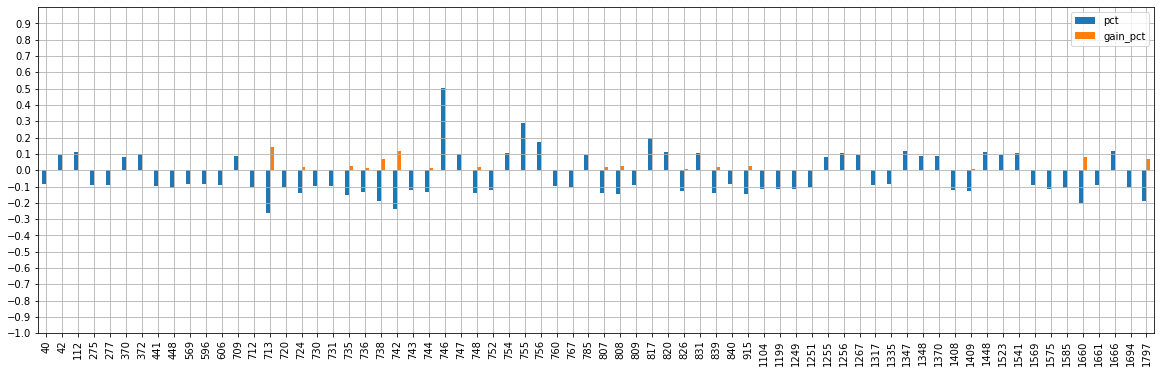

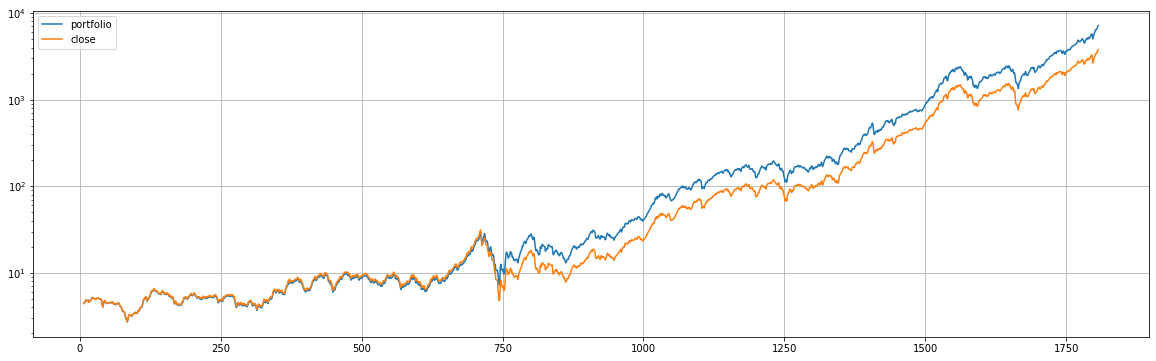

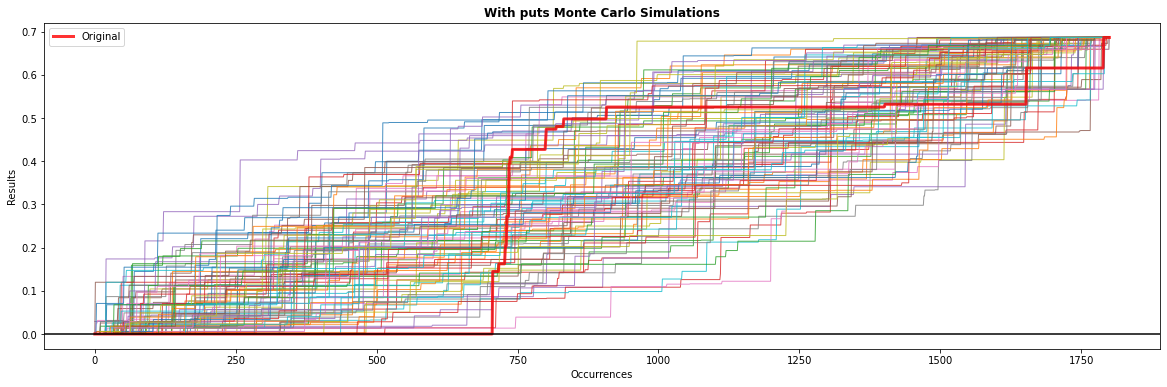

With puts Monte Carlo Simulations {'min': 0.6863053450777569, 'max': 0.6863053450777569, 'mean': 0.6863053450777566, 'median': 0.6863053450777569, 'std': 2.2316322462394835e-16, 'maxdd': nan, 'bust': 0.0, 'goal': 0.0}


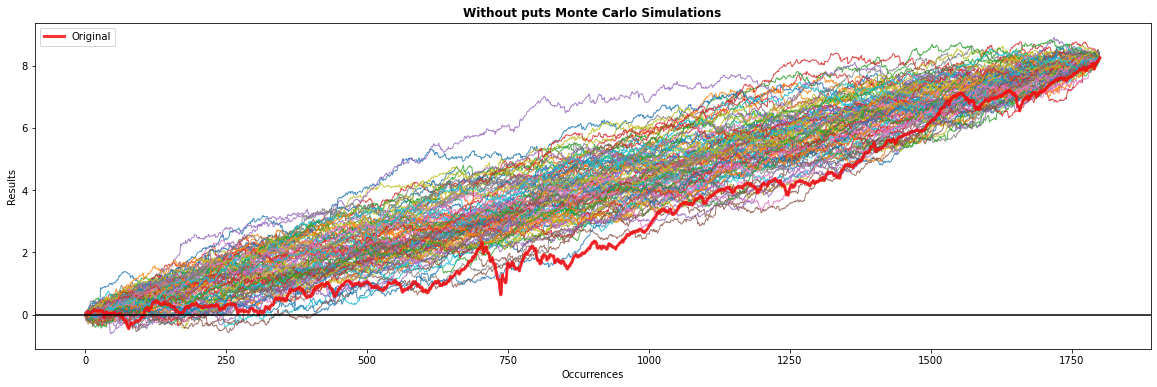

Without puts Monte Carlo Simulations {'min': 8.250132331879207, 'max': 8.250132331879245, 'mean': 8.250132331879227, 'median': 8.250132331879227, 'std': 8.059622581434478e-15, 'maxdd': -0.6192487630767997, 'bust': 0.2, 'goal': 0.8}


In [356]:
doDf(df2, costOfOptions=0.01/100, gainFn=gainPuts, multiplier=1, winThreshold=12/100)
plot(df2)
montecarlo(df2, "With puts Monte Carlo Simulations", "gain_pct")
montecarlo(df2, "Without puts Monte Carlo Simulations", "pct")


Stdev  4.0696146685580254
Strategy ending val  98875.3140060112 Months  1801 1801 Ending val buy and hold  3793.748421052632 3793.748421052611


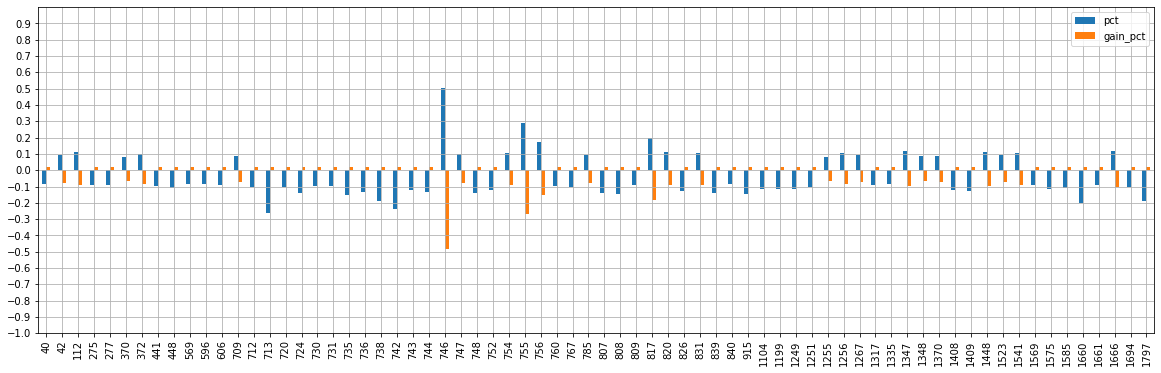

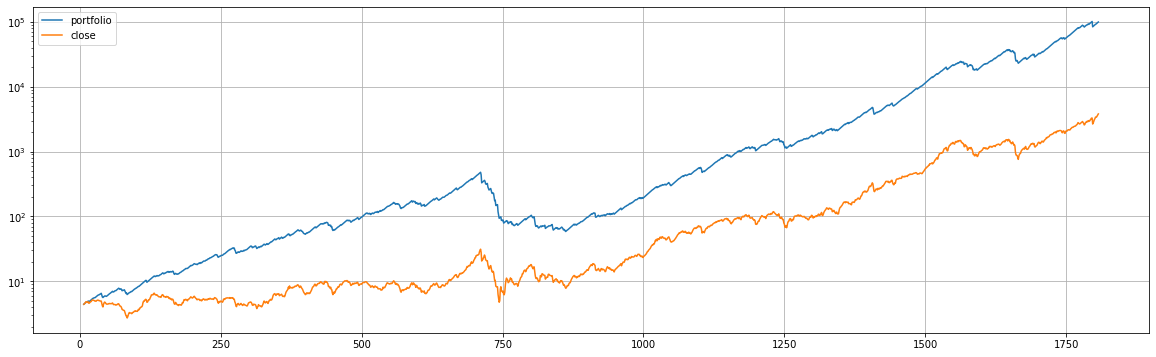

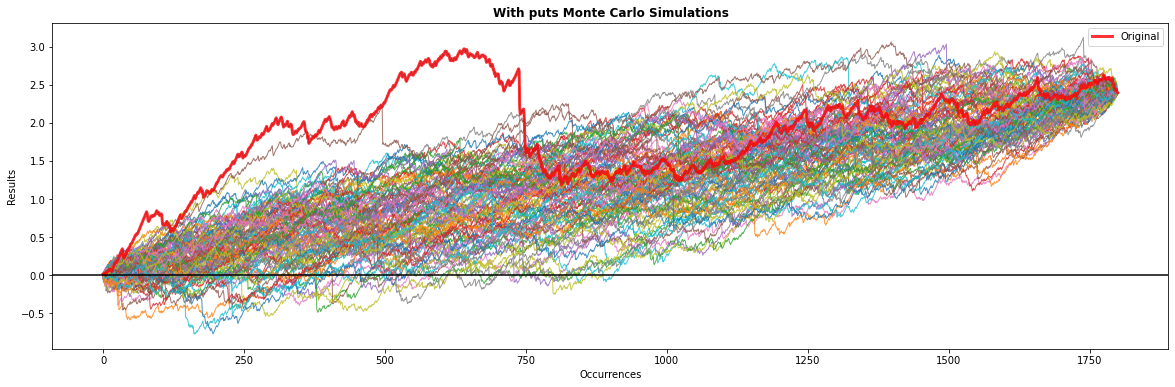

With puts Monte Carlo Simulations {'min': 2.394298542139861, 'max': 2.3942985421399983, 'mean': 2.3942985421399556, 'median': 2.394298542139968, 'std': 3.2982558249243495e-14, 'maxdd': -0.7703354454988353, 'bust': 0.19, 'goal': 0.81}


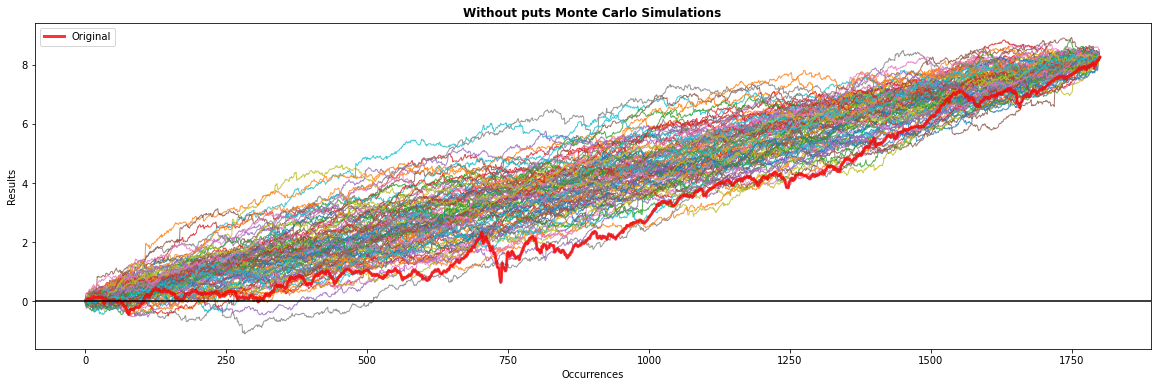

Without puts Monte Carlo Simulations {'min': 8.250132331879206, 'max': 8.250132331879247, 'mean': 8.250132331879223, 'median': 8.250132331879225, 'std': 9.192157965915267e-15, 'maxdd': -1.1052150992428884, 'bust': 0.23, 'goal': 0.77}


In [289]:
# ATM call sold at premium
premium = 1.8/100 # threshold at which bust is acceptable in montecarlo

def gainCallsATM(row, winThreshold):
    if row["pct"] > premium:
        optionReturns = -(row["pct"] - premium)
        return optionReturns
    elif 0 < row["pct"] < premium:
        optionReturns = premium - row["pct"]
        return optionReturns
    else:
        return premium
doDf(df2, costOfOptions=0, gainFn=gainCallsATM, multiplier=1)
plot(df2)
montecarlo(df2, "With puts Monte Carlo Simulations", "gain_pct")
montecarlo(df2, "Without puts Monte Carlo Simulations", "pct")

Stdev  4.0696146685580254
Strategy ending val  3666.725258112592 Months  1801 1801 Ending val buy and hold  3793.748421052632 3793.748421052611


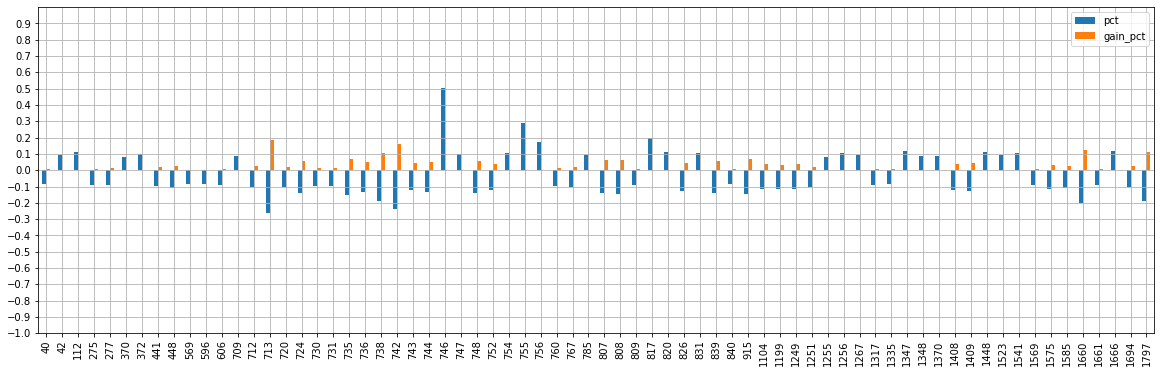

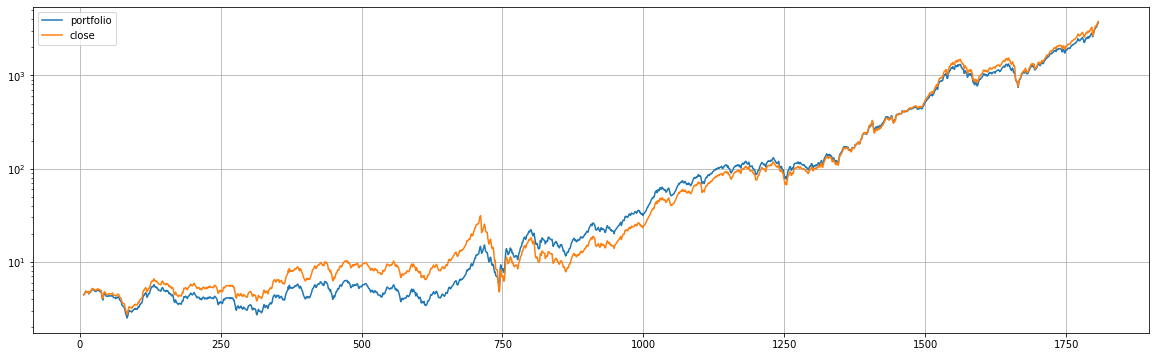

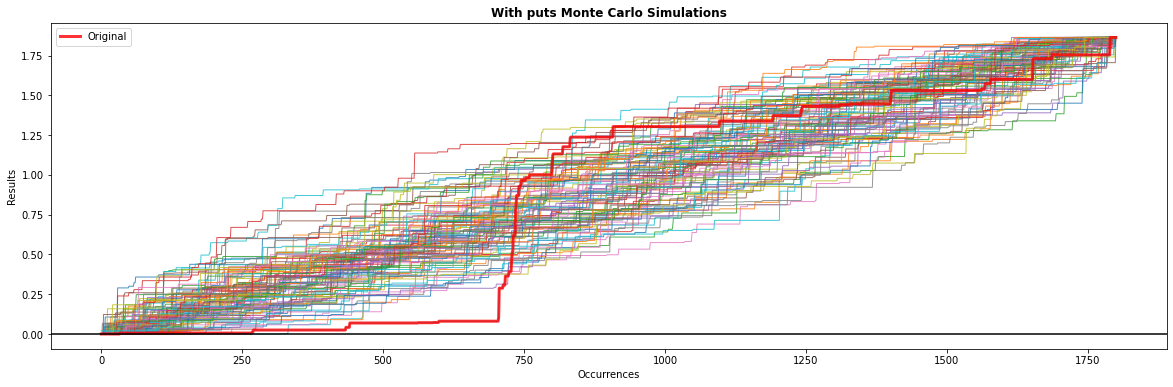

With puts Monte Carlo Simulations {'min': 1.8639581367391966, 'max': 1.8639581367391982, 'mean': 1.8639581367391975, 'median': 1.8639581367391975, 'std': 2.9352539404025466e-16, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


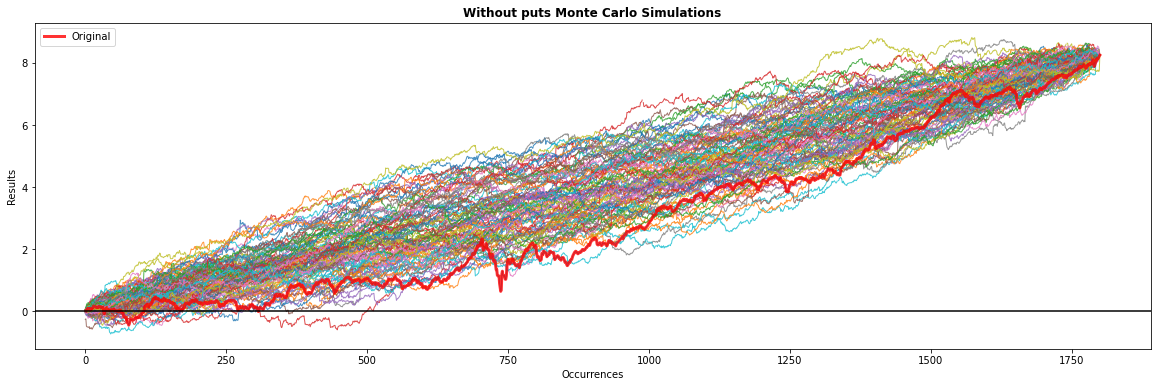

Without puts Monte Carlo Simulations {'min': 8.250132331879204, 'max': 8.250132331879248, 'mean': 8.250132331879225, 'median': 8.250132331879227, 'std': 9.052398281081212e-15, 'maxdd': -0.7349932048977573, 'bust': 0.15, 'goal': 0.85}


In [256]:
doDf(df2, costOfOptions=0.12/100, gainFn=gainPuts, multiplier=1)
plot(df2)
montecarlo(df2, "With puts Monte Carlo Simulations", "gain_pct")
montecarlo(df2, "Without puts Monte Carlo Simulations", "pct")

In [ ]:
doDf(df2, costOfOptions=0.17/100)
plot(df2)
montecarlo(df2, "With puts Monte Carlo Simulations", "gain_pct")
montecarlo(df2, "Without puts Monte Carlo Simulations", "pct")

Stdev  4.0696146685580254
Strategy ending val  3956.4392568984304 Months  1801 1801 Ending val buy and hold  3793.748421052632 3793.748421052611


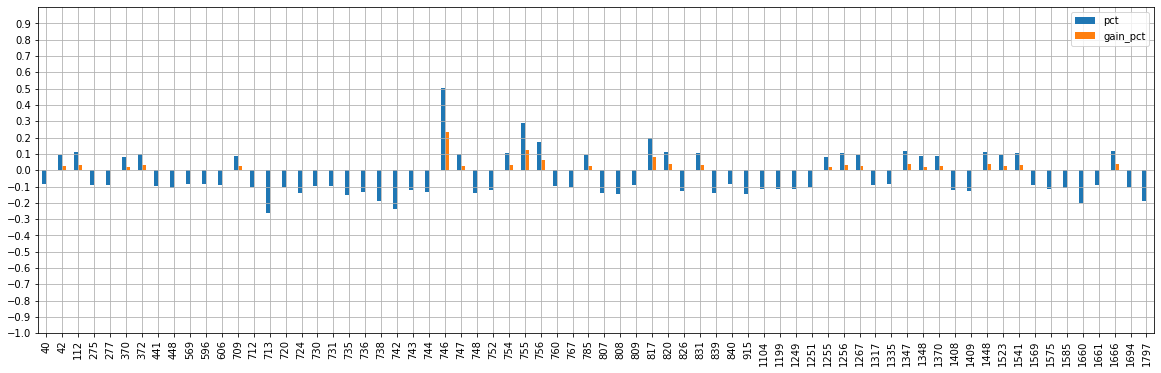

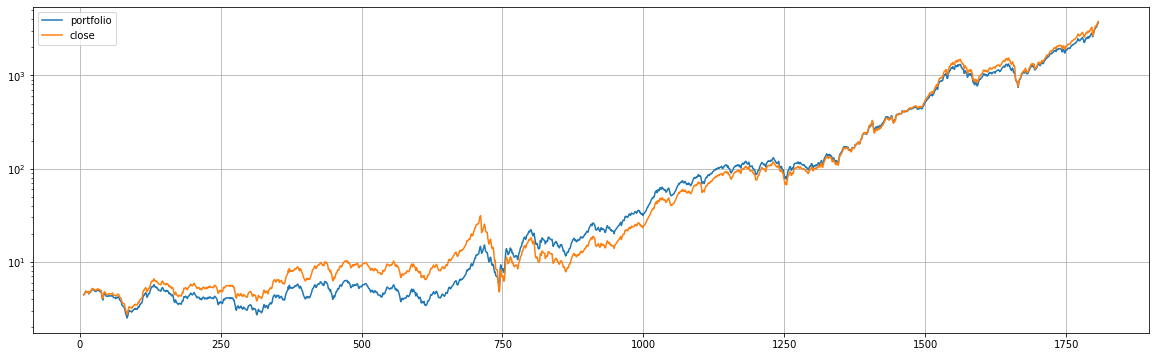

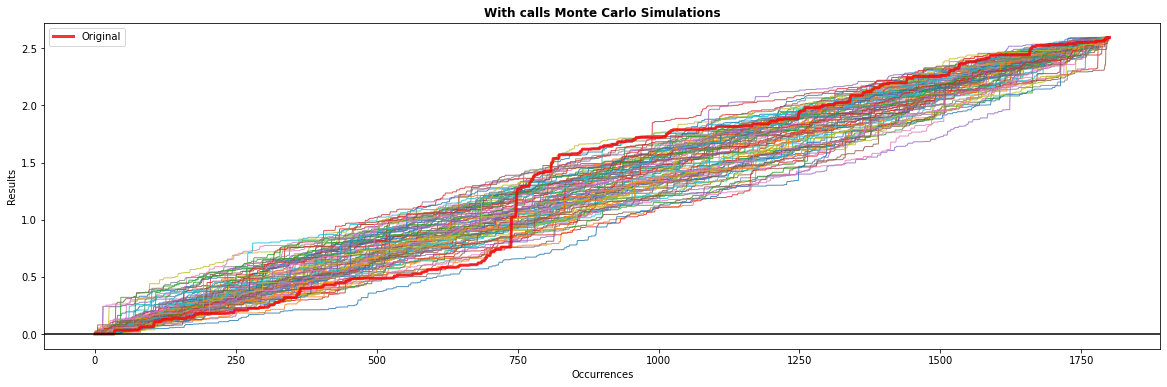

With calls Monte Carlo Simulations {'min': 2.594795077397084, 'max': 2.594795077397089, 'mean': 2.5947950773970865, 'median': 2.5947950773970865, 'std': 1.0533682438213005e-15, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


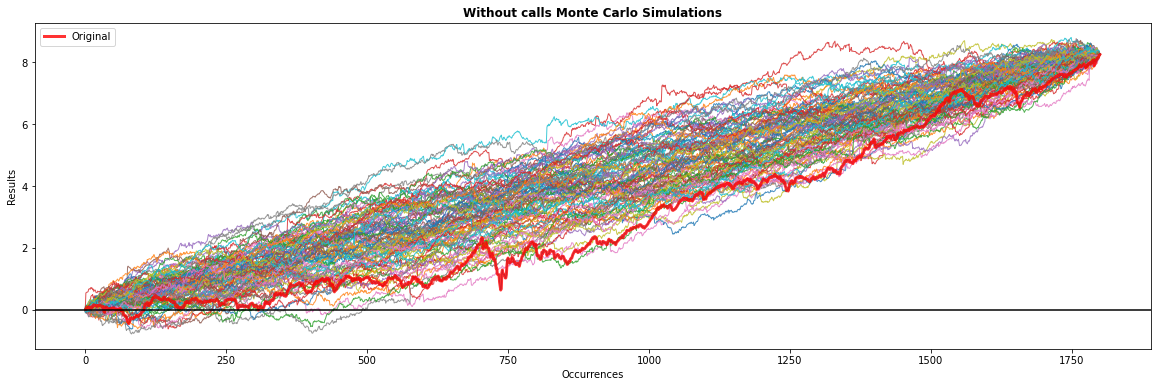

Without calls Monte Carlo Simulations {'min': 8.250132331879206, 'max': 8.250132331879247, 'mean': 8.250132331879223, 'median': 8.250132331879227, 'std': 8.84222148719265e-15, 'maxdd': -0.7815439286166641, 'bust': 0.16, 'goal': 0.84}


In [276]:
doDf(df2, winThreshold=0.04, costOfOptions=0.125/100, gainFn=gainCalls, multiplier=1)
plot(df2)
montecarlo(df2, "With calls Monte Carlo Simulations", "gain_pct")
montecarlo(df2, "Without calls Monte Carlo Simulations", "pct")

In [159]:
df2[["Unnamed: 0", "Unnamed: 1", "pct"]].head(20)

Unnamed: 0 Unnamed: 1       pct
7     1871.01       4.44       NaN
8     1871.02        4.5  0.013514
9     1871.03       4.61  0.024444
10    1871.04       4.74  0.028200
11    1871.05       4.86  0.025316
12    1871.06       4.82 -0.008230
13    1871.07       4.73 -0.018672
14    1871.08       4.79  0.012685
15    1871.09       4.84  0.010438
16     1871.1       4.59 -0.051653
17    1871.11       4.64  0.010893
18    1871.12       4.74  0.021552
19    1872.01       4.86  0.025316
20    1872.02       4.88  0.004115
21    1872.03       5.04  0.032787
22    1872.04       5.18  0.027778
23    1872.05       5.18  0.000000
24    1872.06       5.13 -0.009653
25    1872.07        5.1 -0.005848
26    1872.08       5.04 -0.011765

In [193]:
# For each month, if the change is greater than the threshold then add the gain, else subtract the loss.
# Plain vanilla, rest is all invested in mkt, so gets market returns

winThreshold = 2 * stdev  # capture the tail
multiplier = 2
# Cost, it is 2 sided, remember. 0.25% per month is the typical cost at 2 stdev
costOfOptions = multiplier * 0.085 / 100 # NOTE: LOL, is 1/3rd of what we get

def gain(row):
    if row["pct"] < -winThreshold:
        optionReturns = (-row["pct"] - winThreshold)
        return optionReturns
    elif row["pct"] > winThreshold:
        optionReturns = (row["pct"] - winThreshold)
        return optionReturns
    else:
        return 0


df2["gain_pct"] = df2.apply(lambda row: gain(row), axis=1)
portfolioVal = df2.head(1)["Unnamed: 1"].values[0]
oldPfVal = portfolioVal # Only for sanity checks
pfList = [portfolioVal]
# shift the gain by 1 week for comparison and iterate over all rows of df2
for _, row in df2.shift(-1).iterrows():
    if np.isnan(row["gain_pct"]):
        continue
    # Value from regular change of market
    newPortfolioVal = portfolioVal * (1 - costOfOptions)
    newPortfolioVal += newPortfolioVal * row["pct"]
    optionsBump = portfolioVal * row["gain_pct"] * multiplier / 2
    portfolioVal = newPortfolioVal + optionsBump
    oldPfVal += oldPfVal * row["pct"]
    pfList.append(portfolioVal)
print(
    "Strategy ending val ",
    portfolioVal,
    "Months ",
    len(pfList),
    len(df2),
    "Ending val buy and hold ",
    df2.tail(1)["Unnamed: 1"],
    oldPfVal
)


Strategy ending val  3617.879283917203 Months  1801 1801 Ending val buy and hold  1807    3793.748421
Name: Unnamed: 1, dtype: object 3793.748421052611


In [209]:
# Puts only

# For each month, if the change is greater than the threshold then add the gain, else subtract the loss.
# Plain vanilla, rest is all invested in mkt, so gets market returns

winThreshold = 2 * stdev  # capture the tail
multiplier = 1
# Cost, it is 2 sided, remember. 0.25% per month is the typical cost at 2 stdev
costOfOptions = multiplier * 0.12 / 100 # NOTE: LOL, is 1/3rd of what we get

def gain(row):
    if row["pct"] < -winThreshold:
        optionReturns = (-row["pct"] - winThreshold)
        return optionReturns
    else:
        return 0


df2["gain_pct"] = df2.apply(lambda row: gain(row), axis=1)
portfolioVal = df2.head(1)["Unnamed: 1"].values[0]
oldPfVal = portfolioVal # Only for sanity checks
pfList = [portfolioVal]
# shift the gain by 1 week for comparison and iterate over all rows of df2
for _, row in df2.shift(-1).iterrows():
    if np.isnan(row["gain_pct"]):
        continue
    # Value from regular change of market
    newPortfolioVal = portfolioVal * (1 - costOfOptions)
    newPortfolioVal += newPortfolioVal * row["pct"]
    optionsBump = portfolioVal * row["gain_pct"] * multiplier
    portfolioVal = newPortfolioVal + optionsBump
    oldPfVal += oldPfVal * row["pct"]
    pfList.append(portfolioVal)
print(
    "Strategy ending val ",
    portfolioVal,
    "Months ",
    len(pfList),
    len(df2),
    "Ending val buy and hold ",
    df2.tail(1)["Unnamed: 1"],
    oldPfVal
)


Strategy ending val  3666.725258112592 Months  1801 1801 Ending val buy and hold  1807    3793.748421
Name: Unnamed: 1, dtype: object 3793.748421052611


# Plotting the wins

<AxesSubplot:>

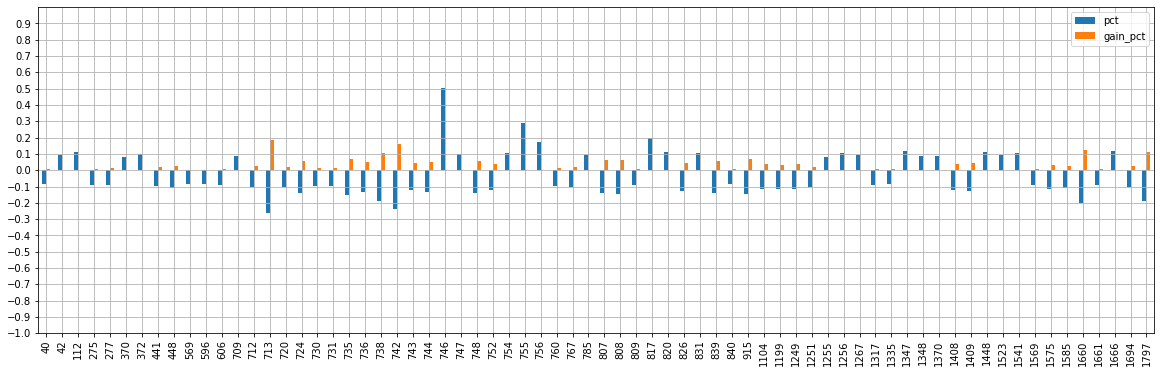

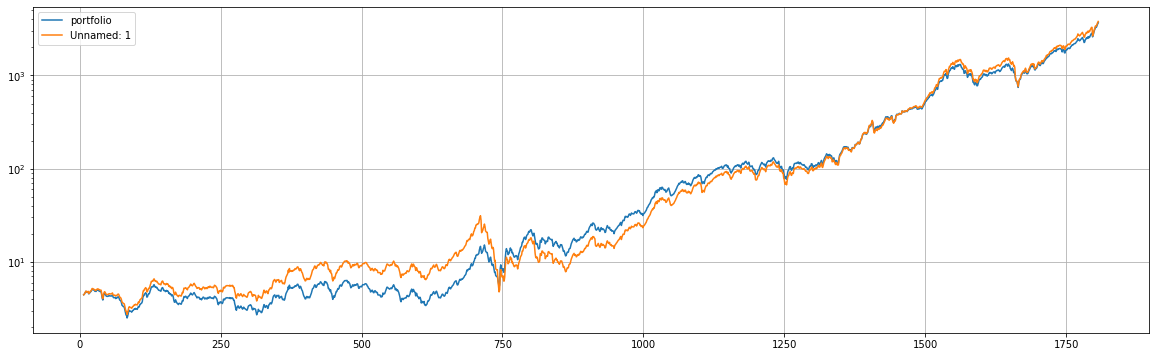

In [215]:
df2[(df2["pct"] > winThreshold) | (df2["pct"] < -winThreshold)][
    ["pct", "gain_pct"]
].plot(
    kind="bar",
    ylim=(-1, 1),
    figsize=(20, 6),
    grid=True,
    yticks=tuple(np.arange(-1, 1, 0.1)),
)
df2["portfolio"] = pfList
df2[['portfolio','Unnamed: 1']].plot(figsize=(20,6), grid=True, logy=True)

In [211]:
print(
    "2SD wins ",
    len(df2[(df2["pct"] > winThreshold)]),
    "2SD losses ",
    len(df2[(df2["pct"] < -winThreshold)]),
)


2SD wins  24 2SD losses  46


In [213]:
# How we do in the drawdowns
df2[(df2['pct'] < -winThreshold)][["Unnamed: 1", "portfolio", "pct", "gain_pct"]]

Unnamed: 1    portfolio       pct  gain_pct
40           4.19     4.052636 -0.087146  0.005754
275          4.84     3.558014 -0.088512  0.007120
277          4.18     3.105683 -0.093275  0.011883
441          8.35     5.190522 -0.098272  0.016880
448          6.64     4.218676 -0.108725  0.027333
569          7.04     3.876173 -0.083333  0.001941
596           8.1     4.323569 -0.082673  0.001280
606          6.81     3.623923 -0.089572  0.008180
712         27.99    13.472393 -0.105751  0.024359
713         20.58    12.363957 -0.264737  0.183345
720         21.52    13.101688 -0.101086  0.019694
724         17.92    11.566626 -0.137632  0.056240
730         15.86    10.319527 -0.095265  0.013873
731         14.33     9.468408 -0.096469  0.015077
735         11.83     8.397077 -0.148921  0.067529
736         10.25     7.704889 -0.133559  0.052166
738          8.44     7.158229 -0.187680  0.106288
742          6.28     6.405858 -0.239709  0.158317
743          5.51     5.877726 -0.122611  0.041219
744          4.77     5.393219 -0.134301  0.052909
748          7.12     8.538588 -0.138015  0.056622
752          6.25     7.773518 -0.118477  0.037084
760          9.55    11.972661 -0.097353  0.015961
767          9.81    12.471000 -0.101648  0.020256
807         14.37    18.633453 -0.141577  0.060185
808         12.28    17.097725 -0.145442  0.064050
809          11.2    15.687389 -0.087948  0.006556
826         10.83    15.620481 -0.125908  0.044516
839         10.58    16.006395 -0.137734  0.056342
840          9.67    14.686042 -0.086011  0.004619
915         15.09    22.568838 -0.147458  0.066065
1104        55.63    68.973879 -0.116844  0.035452
1199        76.06    87.343659 -0.115067  0.033675
1249        79.31    89.203083 -0.116717  0.035324
1251        68.12    78.367668 -0.104038  0.022646
1317        104.7   112.566946 -0.091934  0.010542
1335        118.3   125.261091 -0.087191  0.005799
1408        280.2   283.987312 -0.120803  0.039411
1409          245   260.574959 -0.125625  0.044232
1569      1185.85  1052.756734 -0.091825  0.010432
1575      1044.64   954.217614 -0.113585  0.032193
1585       903.59   840.733488 -0.108903  0.027511
1660        968.8   950.712847 -0.203911  0.122519
1661       883.04   872.292283 -0.088522  0.007130
1694      1185.31  1155.833358 -0.105555  0.024162
1797  2652.393636  2594.552620 -0.190681  0.109288

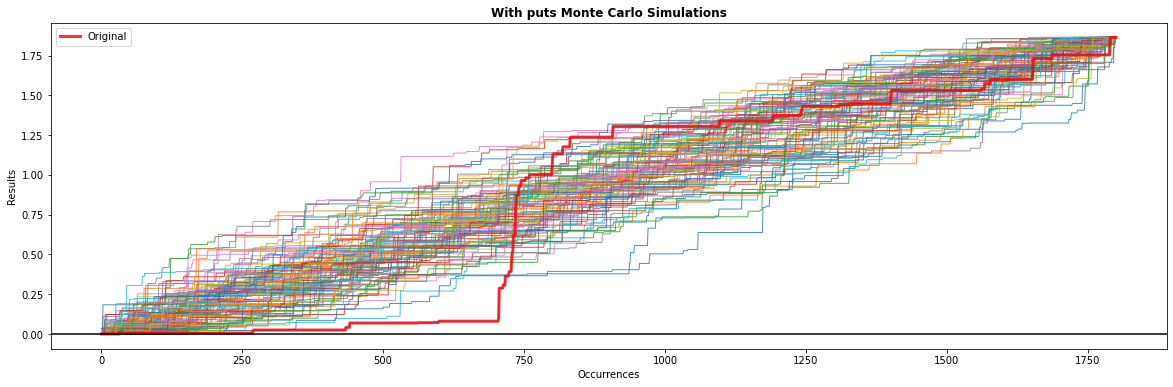

{'min': 1.8639581367391966, 'max': 1.8639581367391984, 'mean': 1.8639581367391975, 'median': 1.8639581367391975, 'std': 2.9182378321513755e-16, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


In [214]:

mc = df2['gain_pct'].montecarlo(sims=100, bust=-0.25, goal=1)
mc.plot(title="With puts Monte Carlo Simulations", figsize=(20, 6))
print(mc.stats)

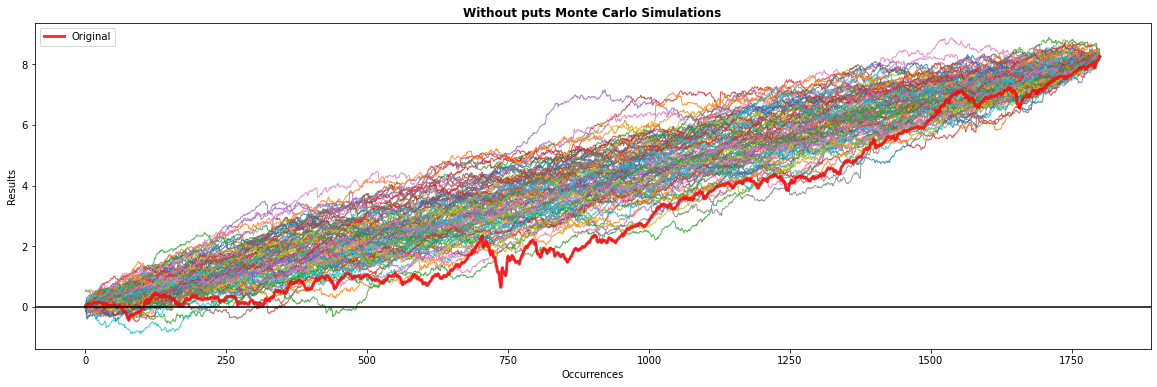

{'min': 8.250132331879206, 'max': 8.250132331879252, 'mean': 8.250132331879229, 'median': 8.250132331879225, 'std': 8.293509287490712e-15, 'maxdd': -0.901446331202156, 'bust': 0.23, 'goal': 0.77}


In [223]:

mc = df2['pct'].montecarlo(sims=100, bust=-0.2, goal=1)
mc.plot(title="Without puts Monte Carlo Simulations", figsize=(20, 6))
print(mc.stats)

In [194]:
# If you want to dump to csv
# df2["power"] = pfList
# df2.to_csv("/Users/shan/Documents/power3.csv", index=False)

/var/folders/b7/nt75slqx7lgc80c_xh9gxg640000gn/T/ipykernel_93425/1493197684.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# With no mkt investment at all, pure barbell

In [179]:
# For each month, if the change is greater than the threshold then add the gain, else subtract the loss.
# BARBELL

df3 = df2.copy()

winThreshold = 2 * stdev  # capture the tail

multiplier = 1 # Must be divisible by 2 if following is False
usePutsOnly = True

interestPerMo = 6.25 / (100 * 12) # NOTE: LOL! OR Get by selling calls?
costOfOptions = (multiplier * 0.25 / 100) - interestPerMo 

def gain(row):
    if row["pct"] < -winThreshold:
        if usePutsOnly:
            # Do not divide the multiplier by 2
            retVal = (-row["pct"] - winThreshold) * multiplier
            return retVal
        else:
            retVal = (-row["pct"] - winThreshold) * multiplier / 2
            return retVal
    elif row["pct"] > winThreshold:
        if usePutsOnly:
            return 0
        else:
            retVal = (row["pct"] - winThreshold) * multiplier / 2
            return retVal
    return 0

df3["gain_pct"] = df3.apply(lambda row: gain(row), axis=1)
# shift the gain by 1 week for comparison
portfolioVal = df3.head(1)["Unnamed: 1"].values[0]
pfList = [portfolioVal]
# iterate over all rows of df3
for i, row in df3.shift(-1).iterrows():
    # Check gain_pct is nan
    if np.isnan(row["gain_pct"]):
        continue
    newPortfolioVal = portfolioVal * (1 - costOfOptions)
    optionsBump = portfolioVal * row["gain_pct"]
    portfolioVal = newPortfolioVal + optionsBump
    oldPfVal += oldPfVal * row["pct"]
    pfList.append(portfolioVal)
print(portfolioVal, len(pfList), len(df3), df3.tail(1)["Unnamed: 1"])


3462.4578147174284 1801 1801 1807    3793.748421
Name: Unnamed: 1, dtype: object


<AxesSubplot:>

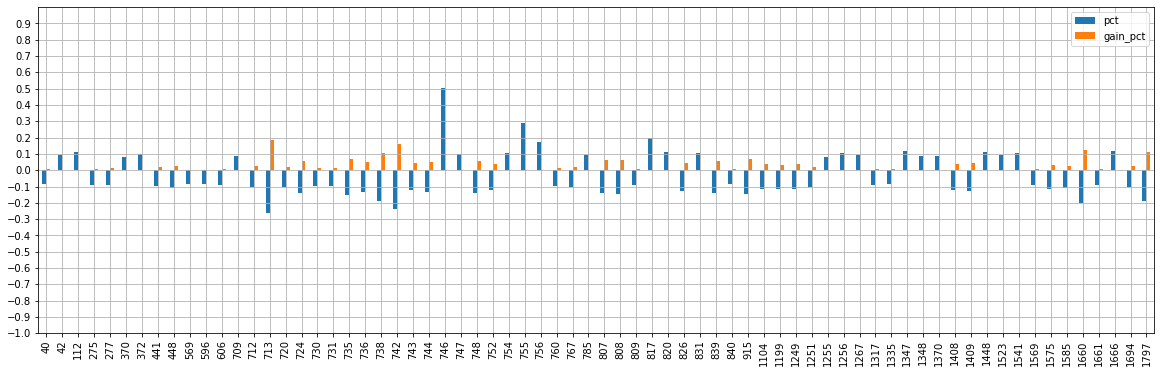

In [182]:
df3[(df3["pct"] > winThreshold) | (df3["pct"] < -winThreshold)][
    ["pct", "gain_pct"]
].plot(
    kind="bar",
    ylim=(-1, 1),
    figsize=(20, 6),
    grid=True,
    yticks=tuple(np.arange(-1, 1, 0.1)),
)


<AxesSubplot:>

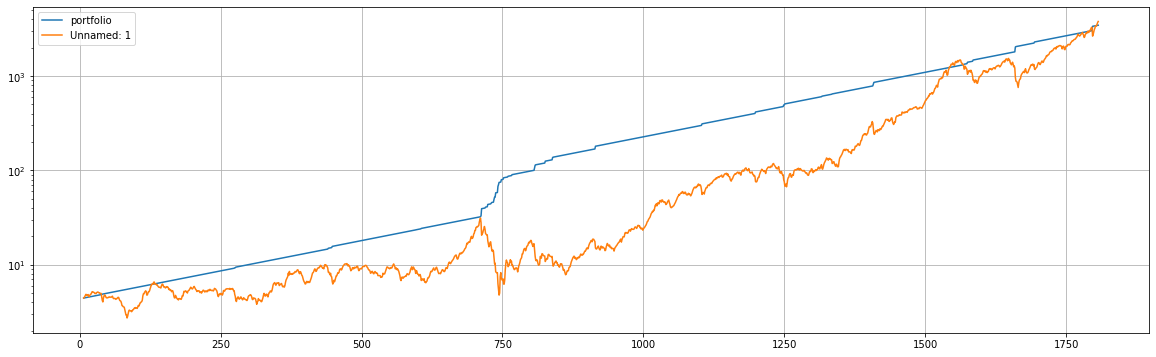

In [181]:
df3["portfolio"] = pfList
df3[['portfolio','Unnamed: 1']].plot(figsize=(20,6), grid=True, logy=True)

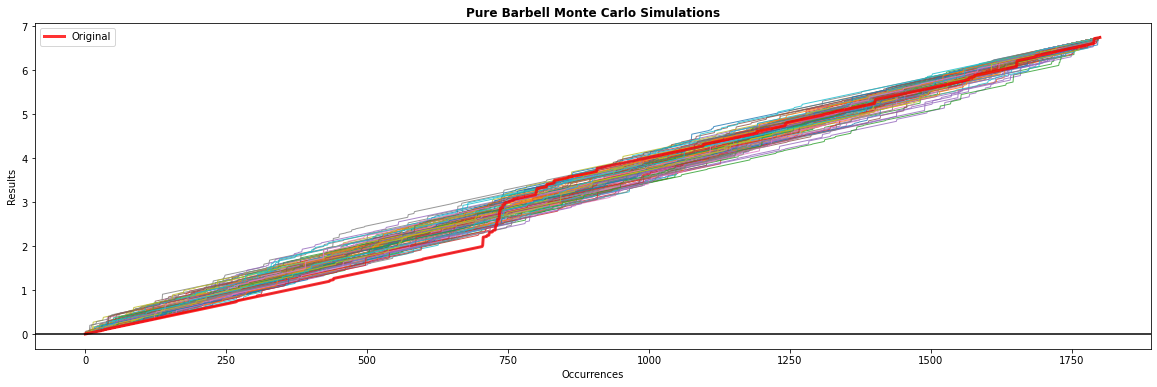

{'min': 6.741666470072734, 'max': 6.7416664700728015, 'mean': 6.741666470072775, 'median': 6.741666470072774, 'std': 1.1659632469897484e-14, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


In [61]:

mc = df3['gain_pct'].montecarlo(sims=100, bust=-0.2, goal=1)
mc.plot(title="Pure Barbell Monte Carlo Simulations", figsize=(20, 6))
print(mc.stats)

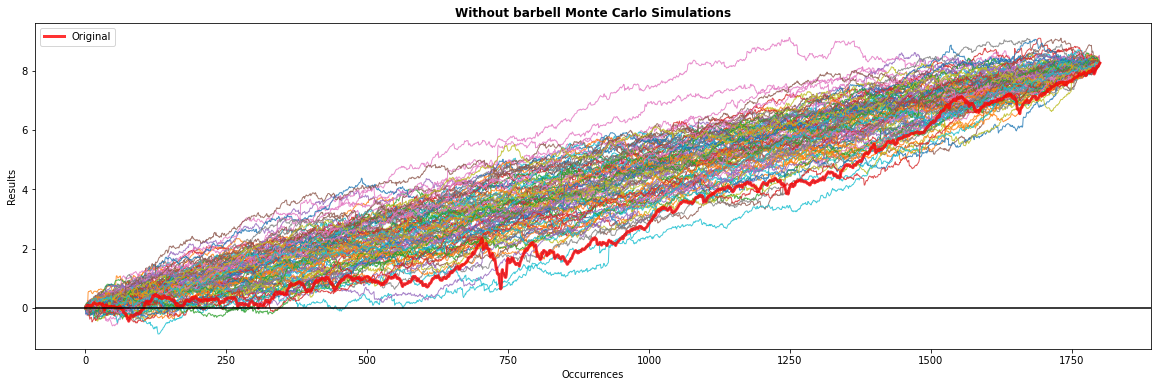

{'min': 8.250132331879191, 'max': 8.250132331879243, 'mean': 8.250132331879223, 'median': 8.250132331879225, 'std': 8.84222148719265e-15, 'maxdd': -0.8811239116844646, 'bust': 0.28, 'goal': 0.72}


In [43]:

mc = df3['pct'].montecarlo(sims=100, bust=-0.2, goal=1)
mc.plot(title="Without barbell Monte Carlo Simulations", figsize=(20, 6))
print(mc.stats)

In [209]:
print(df2[["Unnamed: 1", "portfolio", "pct", "gain_pct"]].tail(20))

       Unnamed: 1    portfolio       pct  gain_pct
1788      2890.17  2890.170000  0.012422  0.002751
1789  2996.113636  2996.113636  0.036657  0.002751
1790  2897.498182  2897.498182 -0.032914  0.002751
1791     2982.156  2982.156000  0.029218  0.002751
1792      2977.68  2977.680000 -0.001501  0.002751
1793    3104.9045  3104.904500  0.042726  0.002751
1794  3176.749524  3176.749524  0.023139  0.002751
1795  3278.202857  3278.202857  0.031936  0.002751
1796  3277.314211  3287.222625 -0.000271  0.002751
1797  2652.393636  3660.099318 -0.190681  0.113432
1798  2761.975238  3670.169850  0.041314  0.002751
1799     2919.615  3680.268090  0.057075  0.002751
1800  3104.660909  3690.394115  0.063380  0.002751
1801  3207.619091  3700.548001  0.033162  0.002751
1802      3391.71  3710.729825  0.057392  0.002751
1803  3365.516667  3720.939664 -0.007723  0.002751
1804  3418.701364  3731.177594  0.015803  0.002751
1805    3548.9925  3741.443693  0.038111  0.002751
1806      3695.31  3751.738039 

# Daily DOW data

In [329]:
df5 = pd.read_csv("/Users/shan/Documents/RWRI Code/USETHIS.csv")
df5 = df5[5400:] # Because mkt was closed for 6mo
# reverse df2
# df2 = df2.iloc[::-1]

df5.head(10)

Date  Value
5400  1914-12-14  56.76
5401  1914-12-15  55.07
5402  1914-12-16  55.35
5403  1914-12-17  55.36
5404  1914-12-18  55.09
5405  1914-12-19   55.2
5406  1914-12-21  54.46
5407  1914-12-22  54.42
5408  1914-12-23  53.46
5409  1914-12-24  53.17

In [330]:
df5['Datetime'] = pd.to_datetime(df5['Date'])
df5.set_index(['Datetime'], inplace=True)
df5['Value'] = df5['Value'].str.replace(',', '').astype(float)
df5["Value"] = pd.to_numeric(df5["Value"], downcast="float")

In [331]:
df5.head(1000)["Value"]


Datetime
1914-12-14     56.759998
1914-12-15     55.070000
1914-12-16     55.349998
1914-12-17     55.360001
1914-12-18     55.090000
1914-12-19     55.200001
1914-12-21     54.459999
1914-12-22     54.419998
1914-12-23     53.459999
1914-12-24     53.169998
1914-12-26     53.340000
1914-12-28     54.549999
1914-12-29     54.580002
1914-12-30     54.549999
1914-12-31     54.580002
1915-01-02     54.630001
1915-01-04     55.439999
1915-01-05     55.500000
1915-01-06     55.400002
1915-01-07     56.080002
1915-01-08     56.549999
1915-01-09     56.540001
1915-01-11     57.369999
1915-01-12     57.439999
1915-01-13     57.349998
1915-01-14     57.509998
1915-01-15     57.900002
1915-01-16     57.189999
1915-01-18     58.119999
1915-01-19     58.110001
1915-01-20     58.419998
1915-01-21     58.509998
1915-01-22     58.209999
1915-01-23     58.520000
1915-01-25     58.060001
1915-01-26     58.240002
1915-01-27     57.070000
1915-01-28     57.250000
1915-01-29     56.540001
1915-01-30     5

In [114]:
monthly = df5["Value"].resample('M').ohlc()
print (monthly)

                    open          high           low         close
Datetime                                                          
1914-12-31     56.759998     56.759998     53.169998     54.580002
1915-01-31     54.630001     58.520000     54.630001     57.160000
1915-02-28     55.590000     57.830002     54.220001     55.180000
1915-03-31     55.290001     61.299999     55.290001     60.830002
1915-04-30     61.049999     71.779999     61.049999     71.779999
...                  ...           ...           ...           ...
2021-07-31  34633.531250  35144.308594  33962.039062  34935.468750
2021-08-31  34838.160156  35625.398438  34792.671875  35360.730469
2021-09-30  35312.531250  35443.820312  33843.921875  33843.921875
2021-10-31  34326.460938  35819.558594  34002.921875  35819.558594
2021-11-30  35913.839844  36432.218750  34483.718750  34483.718750

[1284 rows x 4 columns]


In [332]:
weekly = df5["Value"].resample('W').ohlc()
weekly.head()

                    open          high           low         close
Datetime                                                          
1914-12-20     56.759998     56.759998     55.070000     55.200001
1914-12-27     54.459999     54.459999     53.169998     53.340000
1915-01-03     54.549999     54.630001     54.549999     54.630001
1915-01-10     55.439999     56.549999     55.400002     56.540001
1915-01-17     57.369999     57.900002     57.189999     57.189999
1915-01-24     58.119999     58.520000     58.110001     58.520000
1915-01-31     58.060001     58.240002     56.540001     57.160000
1915-02-07     55.590000     57.259998     55.590000     56.330002
1915-02-14     56.310001     57.830002     56.310001     57.200001
1915-02-21     57.020000     57.020000     55.200001     55.200001
1915-02-28     54.400002     55.180000     54.220001     55.180000
1915-03-07     55.290001     56.509998     55.290001     56.410000
1915-03-14     56.980000     56.980000     56.349998     56.34

In [334]:
weekly["pct"] = weekly["close"].pct_change()

In [372]:
wd = weekly[:]["close"].pct_change()
wd.std()

0.025032688

Stdev  2.5032687932252884
Strategy ending val  31345.974764240593 Months  5582 5582 Ending val buy and hold  34483.72 34483.66855370661


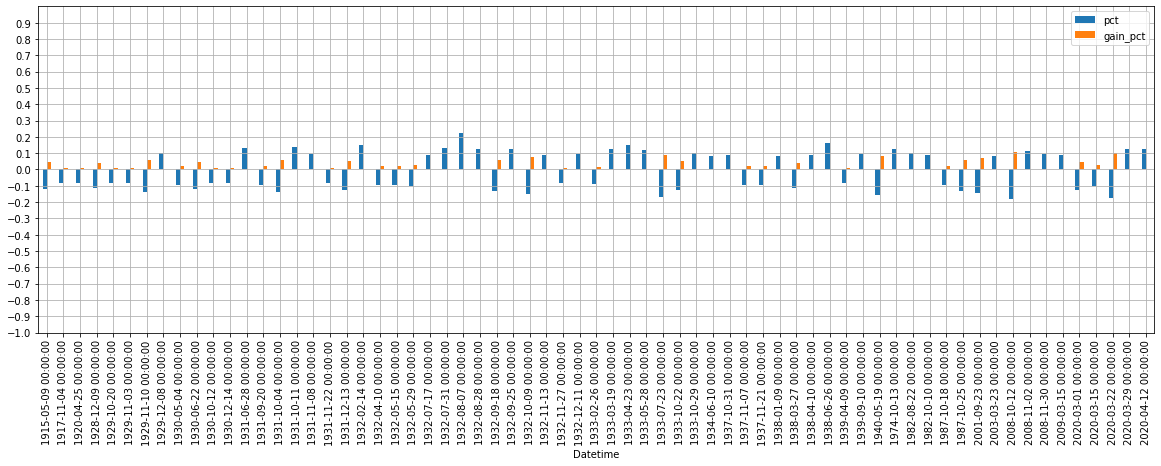

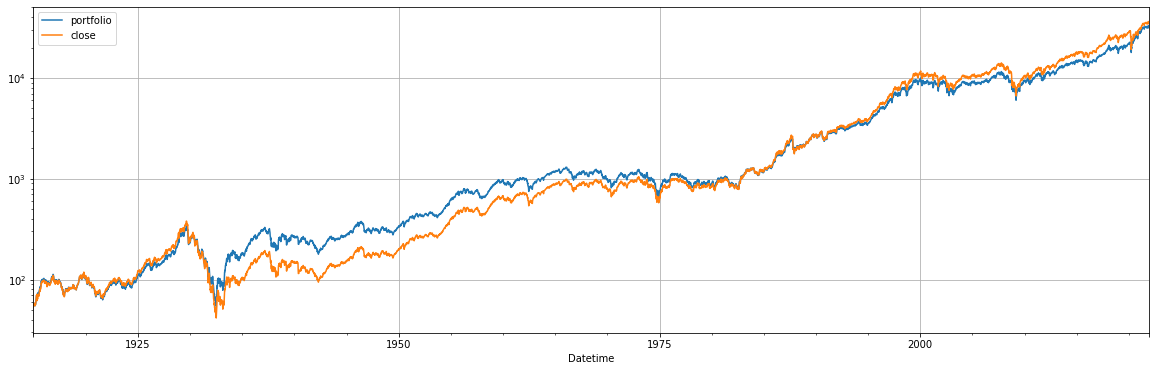

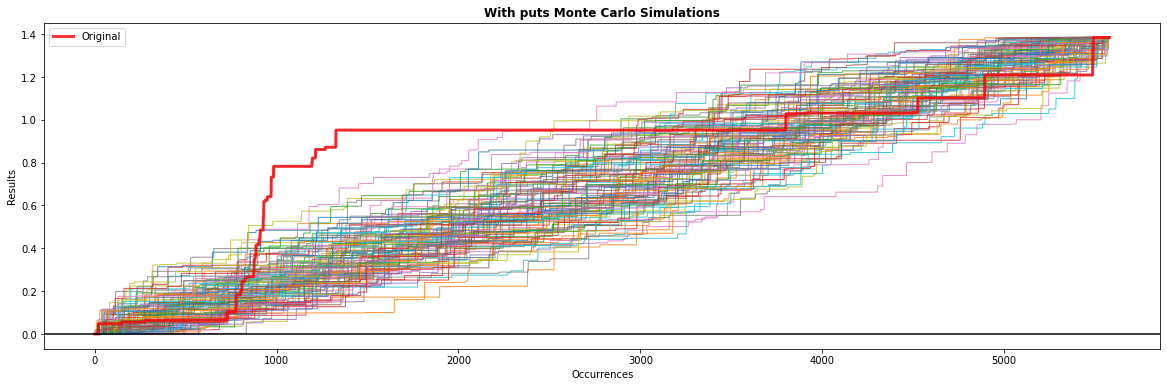

With puts Monte Carlo Simulations {'min': 1.3843036651611336, 'max': 1.3843036651611342, 'mean': 1.384303665161134, 'median': 1.384303665161134, 'std': 1.8537329669870358e-16, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


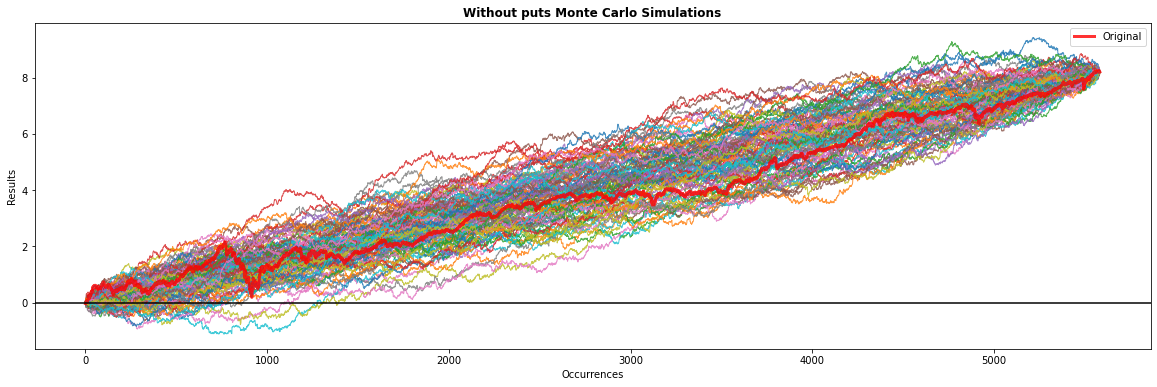

Without puts Monte Carlo Simulations {'min': 8.19879025220871, 'max': 8.19879025220871, 'mean': 8.19879025220871, 'median': 8.19879025220871, 'std': 0.0, 'maxdd': -1.1154186725616455, 'bust': 0.3, 'goal': 0.7}


In [374]:
doDf(weekly, costOfOptions=5/17000, gainFn=gainPuts, multiplier=1, winThreshold=7.5/100)
plot(weekly)
montecarlo(weekly, "With puts Monte Carlo Simulations", "gain_pct")
montecarlo(weekly, "Without puts Monte Carlo Simulations", "pct")


In [362]:
weekly[(weekly["pct"] < -winThreshold)][["close", "pct", "gain_pct"]]


close       pct  gain_pct
Datetime                                    
1915-05-09     62.770000 -0.122221  0.047221
1917-11-04     72.320000 -0.083513  0.008513
1920-04-25     95.760002 -0.083198  0.008198
1928-12-09    257.329987 -0.115096  0.040096
1929-10-20    323.869995 -0.081715  0.006715
1929-11-03    273.510010 -0.085159  0.010159
1929-11-10    236.529999 -0.135205  0.060205
1930-05-04    258.309998 -0.095110  0.020110
1930-06-22    215.300003 -0.118526  0.043526
1930-10-12    193.050003 -0.085505  0.010505
1930-12-14    163.339996 -0.084263  0.009263
1931-09-20    111.739998 -0.097780  0.022780
1931-10-04     92.769997 -0.135898  0.060898
1931-11-22     97.419998 -0.083968  0.008968
1931-12-13     78.930000 -0.124362  0.049362
1932-04-10     64.480003 -0.095652  0.020652
1932-05-15     52.480000 -0.095796  0.020796
1932-05-29     47.700001 -0.100679  0.025679
1932-09-18     66.440002 -0.131957  0.056957
1932-10-09     61.169998 -0.151477  0.076477
1932-11-27     58.889999 -0.081852  0.006852
1933-02-26     50.930000 -0.091185  0.016185
1933-07-23     88.419998 -0.166635  0.091635
1933-10-22     83.639999 -0.125013  0.050013
1937-11-07    125.250000 -0.093508  0.018508
1937-11-21    120.449997 -0.094701  0.019701
1938-03-27    106.629997 -0.114589  0.039589
1939-04-09    121.440002 -0.085749  0.010749
1940-05-19    122.430000 -0.154781  0.079781
1987-10-18   2246.739990 -0.094863  0.019863
1987-10-25   1950.760010 -0.131738  0.056738
2001-09-23   8235.809570 -0.142595  0.067595
2008-10-12   8451.190430 -0.181513  0.106513
2020-03-01  25409.359375 -0.123586  0.048586
2020-03-15  23185.619141 -0.103583  0.028583
2020-03-22  19173.980469 -0.173023  0.098023

Stdev  2.5032687932252884
Strategy ending val  27325677.99696091 Months  5582 5582 Ending val buy and hold  34483.72 34483.66855370661


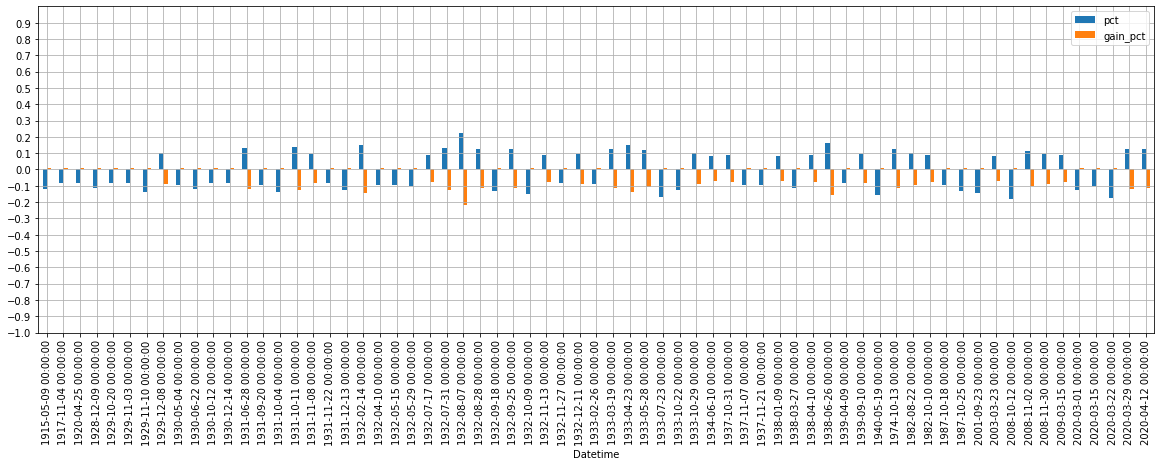

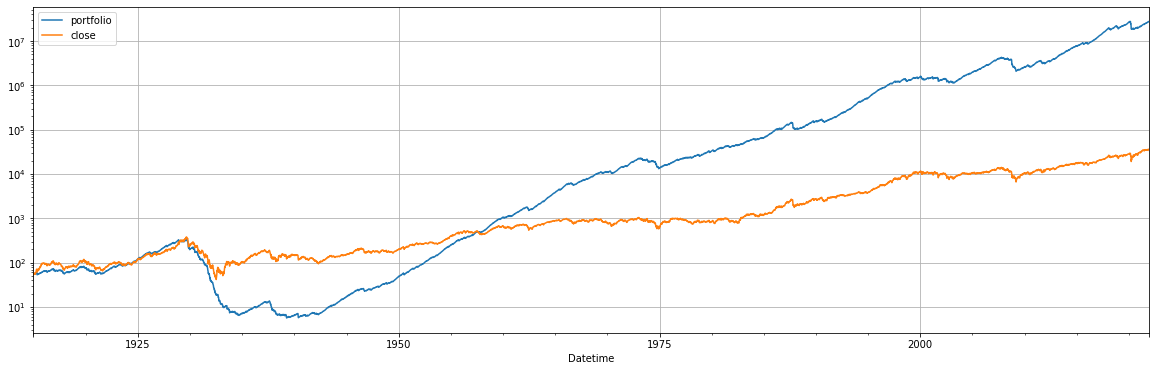

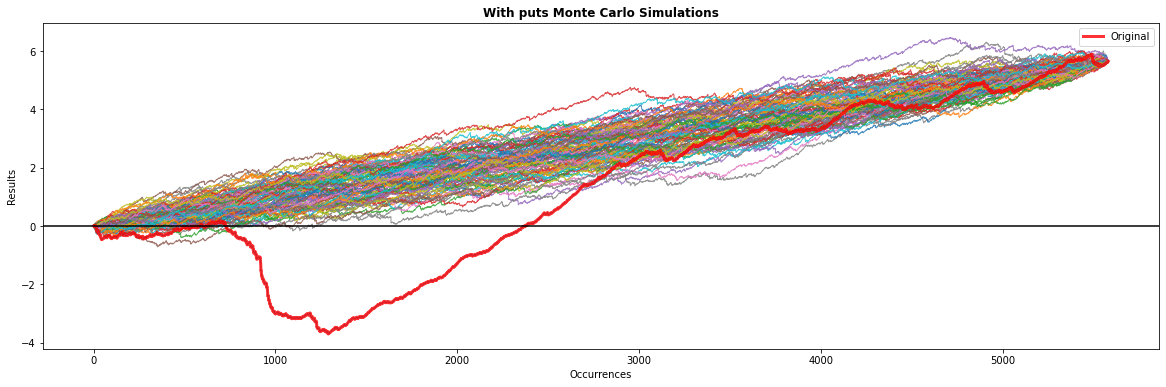

With puts Monte Carlo Simulations {'min': 5.648693381309693, 'max': 5.648693381310624, 'mean': 5.648693381310006, 'median': 5.648693381309962, 'std': 1.9633402830448672e-13, 'maxdd': -3.701051384925858, 'bust': 0.15, 'goal': 0.85}


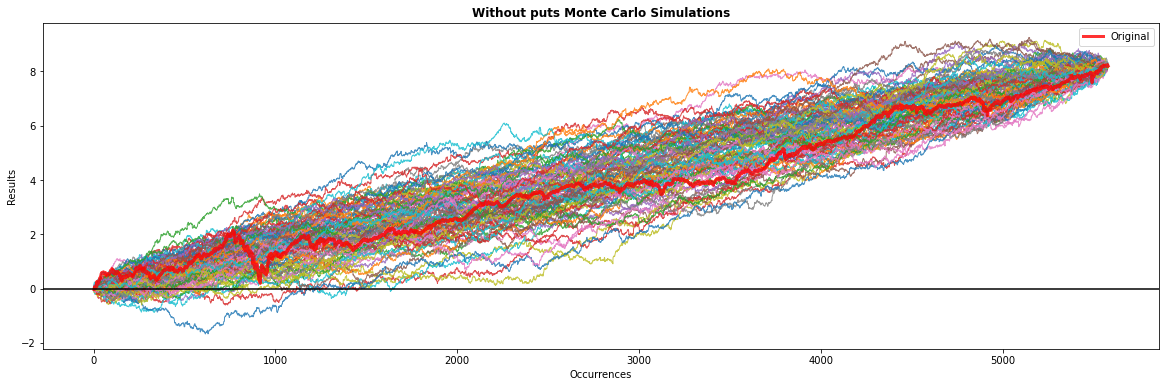

Without puts Monte Carlo Simulations {'min': 8.19879025220871, 'max': 8.19879025220871, 'mean': 8.19879025220871, 'median': 8.19879025220871, 'std': 0.0, 'maxdd': -1.6749932169914246, 'bust': 0.35, 'goal': 0.65}


In [337]:
# ATM call sold at premium
premium = 1.05/100 # threshold at which bust is acceptable in montecarlo

def gainCallsATM(row, winThreshold):
    if row["pct"] > premium:
        optionReturns = -(row["pct"] - premium)
        return optionReturns
    elif 0 < row["pct"] < premium:
        optionReturns = premium - row["pct"]
        return optionReturns
    else:
        return premium
doDf(weekly, costOfOptions=0, gainFn=gainCallsATM, multiplier=1)
plot(weekly)
montecarlo(weekly, "With puts Monte Carlo Simulations", "gain_pct")
montecarlo(weekly, "Without puts Monte Carlo Simulations", "pct")

Stdev  2.5032687932252884
Strategy ending val  3613.9577999824255 Months  5582 5582 Ending val buy and hold  34483.72 34483.66855370661


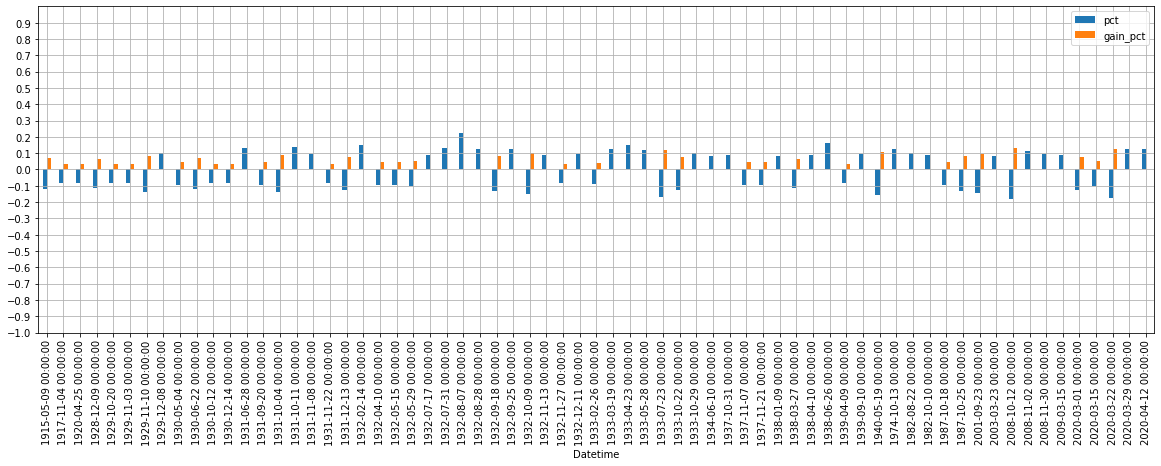

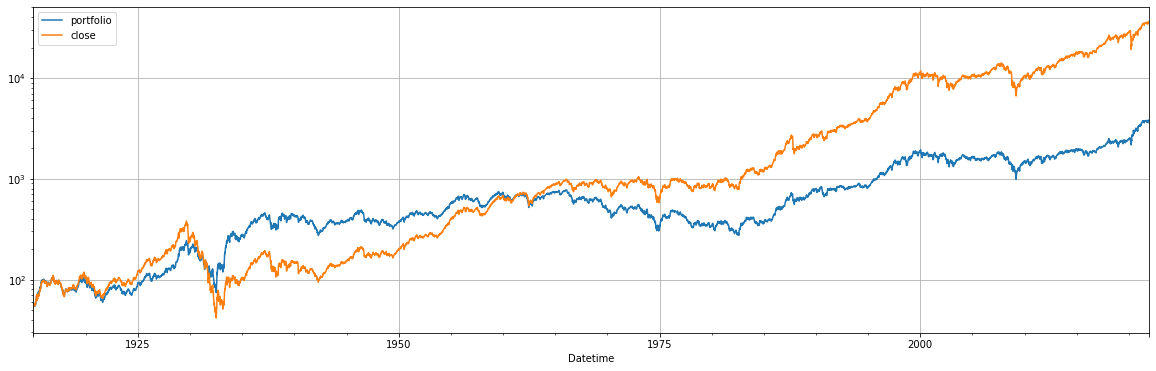

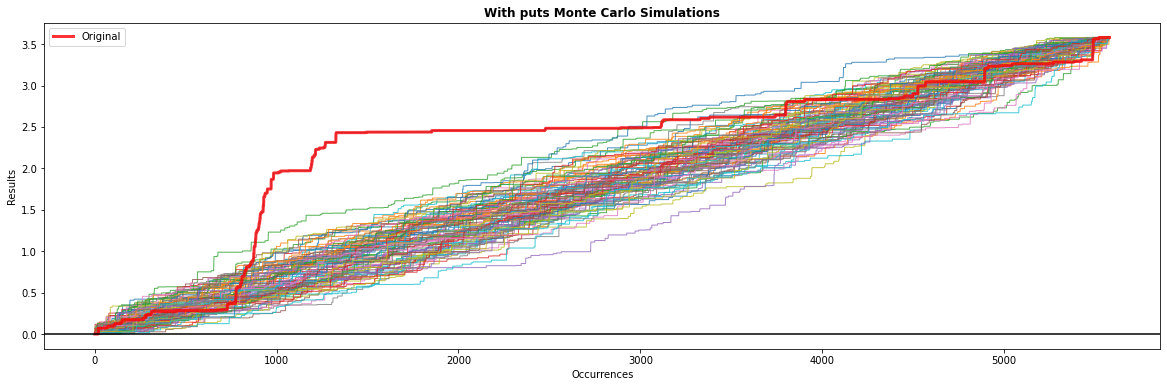

With puts Monte Carlo Simulations {'min': 3.5802084922790582, 'max': 3.580208492279064, 'mean': 3.580208492279061, 'median': 3.580208492279062, 'std': 1.4393595494877737e-15, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


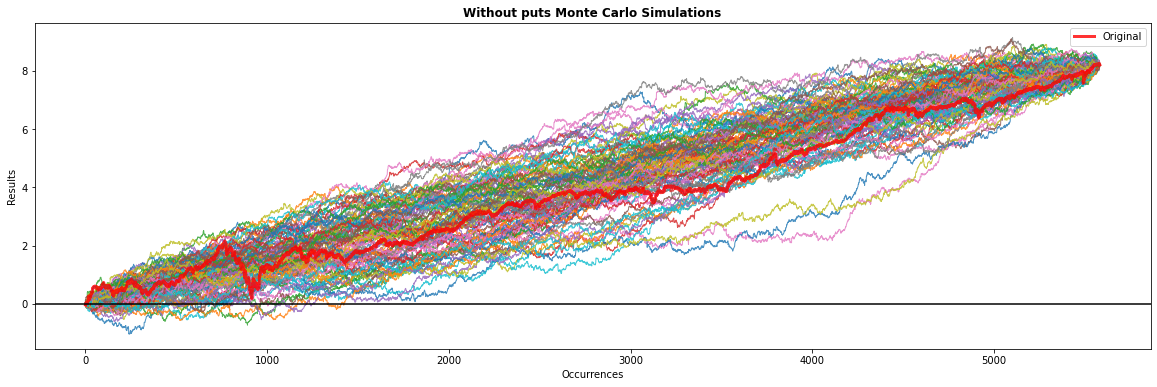

Without puts Monte Carlo Simulations {'min': 8.19879025220871, 'max': 8.19879025220871, 'mean': 8.19879025220871, 'median': 8.19879025220871, 'std': 0.0, 'maxdd': -1.0301098823547363, 'bust': 0.22, 'goal': 0.78}


In [355]:

doDf(weekly, costOfOptions=0.11/100, gainFn=gainPuts, multiplier=1,
    winThreshold=0.05)
plot(weekly)
montecarlo(weekly, "With puts Monte Carlo Simulations", "gain_pct")
montecarlo(weekly, "Without puts Monte Carlo Simulations", "pct")

Stdev  2.5032687932252884
Strategy ending val  3156957.6015246813 Months  5582 5582 Ending val buy and hold  34483.72 34483.66855370661


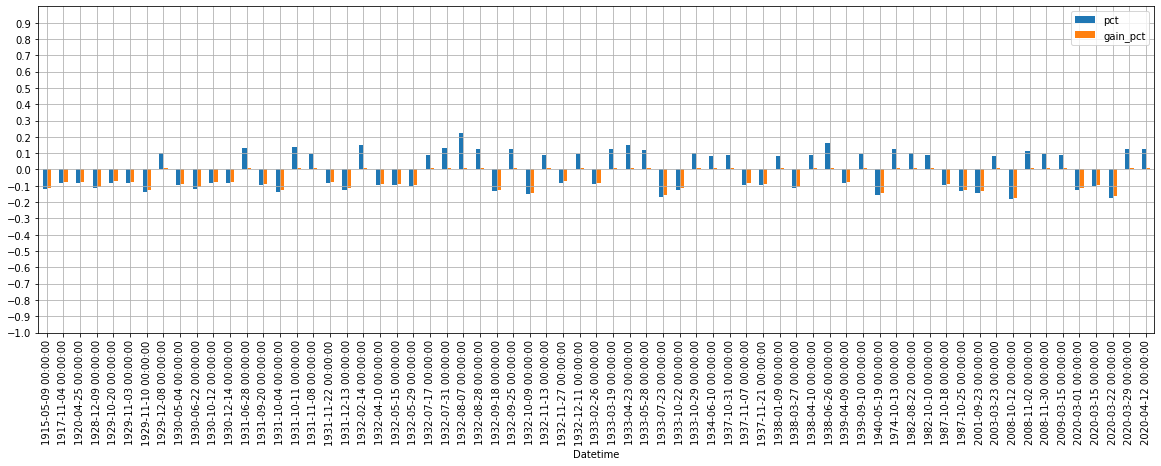

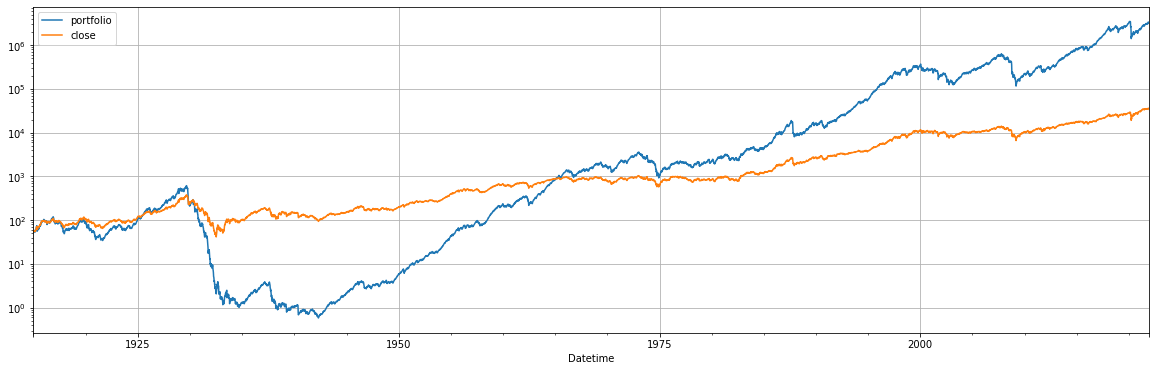

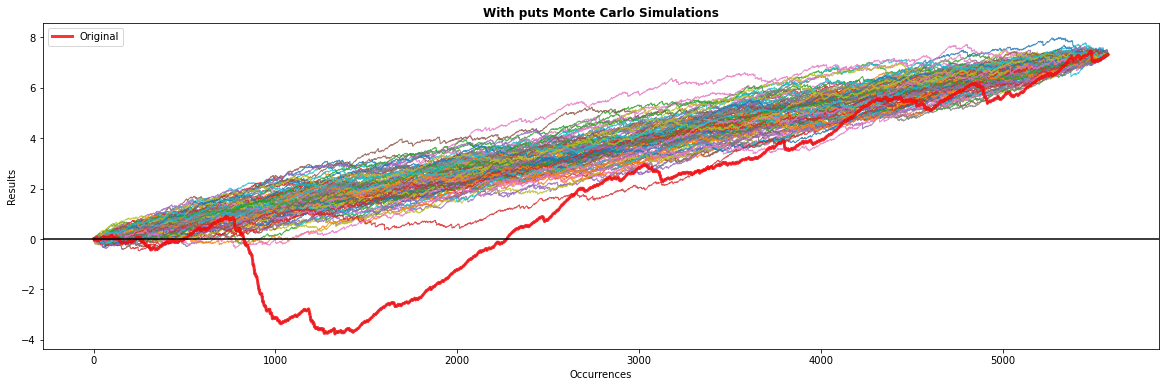

With puts Monte Carlo Simulations {'min': 7.317836794375507, 'max': 7.3178367943763085, 'mean': 7.317836794375922, 'median': 7.317836794375911, 'std': 1.5309267865415107e-13, 'maxdd': -3.7651278252600946, 'bust': 0.13, 'goal': 0.87}


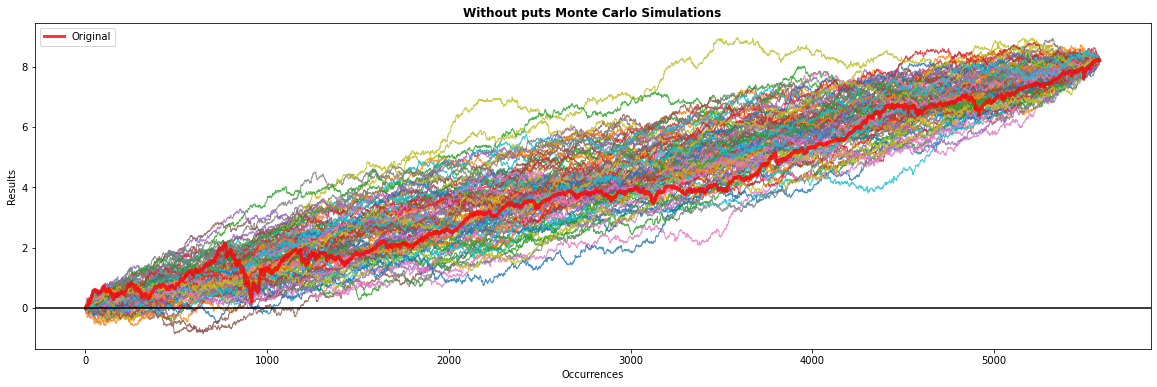

Without puts Monte Carlo Simulations {'min': 8.19879025220871, 'max': 8.19879025220871, 'mean': 8.19879025220871, 'median': 8.19879025220871, 'std': 0.0, 'maxdd': -0.8641068339347839, 'bust': 0.22, 'goal': 0.78}


In [336]:
# ATM put sold at premium
premium = .85/100 # threshold at which bust is acceptable in montecarlo

def gainPutsATM(row, winThreshold):
    if row["pct"] < premium:
        optionReturns = row["pct"] + premium
        return optionReturns
    elif -premium < row["pct"] < 0:
        optionReturns = premium + row["pct"]
        return optionReturns
    else:
        return premium
doDf(weekly, costOfOptions=0, gainFn=gainPutsATM, multiplier=1)
plot(weekly)
montecarlo(weekly, "With puts Monte Carlo Simulations", "gain_pct")
montecarlo(weekly, "Without puts Monte Carlo Simulations", "pct")

Stdev  2.5032687932252884
0.0008500000000000001 0.0008500000000000001 -0.0003623366355895996 0.05 -0.0003623366355895996
0.0008500000000000001 0.0008500000000000001 -0.00047129392623901367 0.05 -0.00047129392623901367
0.0008500000000000001 0.0008500000000000001 -0.0004462003707885742 0.05 -0.0004462003707885742
0.0008500000000000001 0.0008500000000000001 -0.0001806020736694336 0.05 -0.0001806020736694336
0.0008500000000000001 0.0008500000000000001 -0.0002824068069458008 0.05 -0.0002824068069458008
0.0008500000000000001 0.0008500000000000001 -0.00027048587799072266 0.05 -0.00027048587799072266
0.0008500000000000001 0.0008500000000000001 -0.0001118779182434082 0.05 -0.0001118779182434082
0.0008500000000000001 0.0008500000000000001 -0.0003272891044616699 0.05 -0.0003272891044616699
0.0008500000000000001 0.0008500000000000001 -0.0006843805313110352 0.05 -0.0006843805313110352
0.0008500000000000001 0.0008500000000000001 -0.0004509091377258301 0.05 -0.0004509091377258301
0.000850000000000000

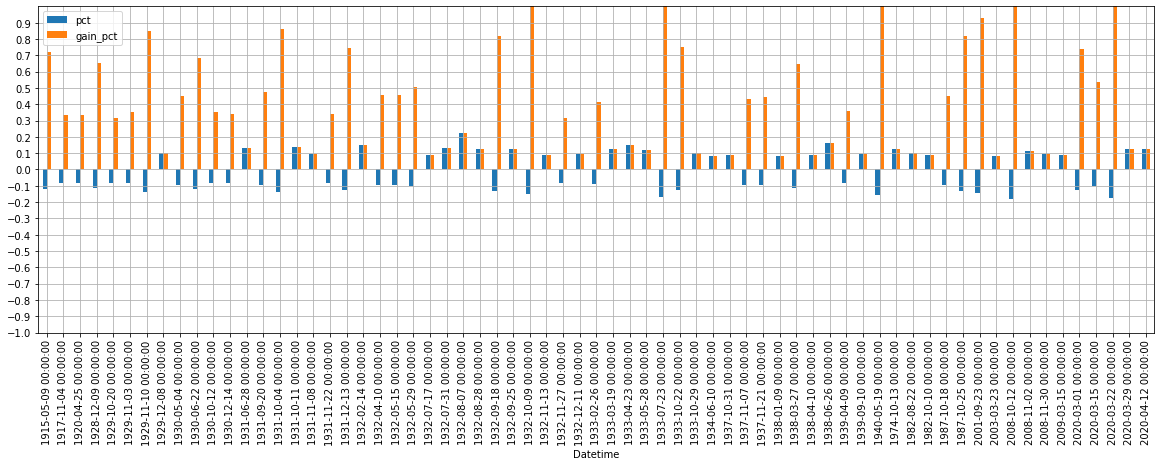

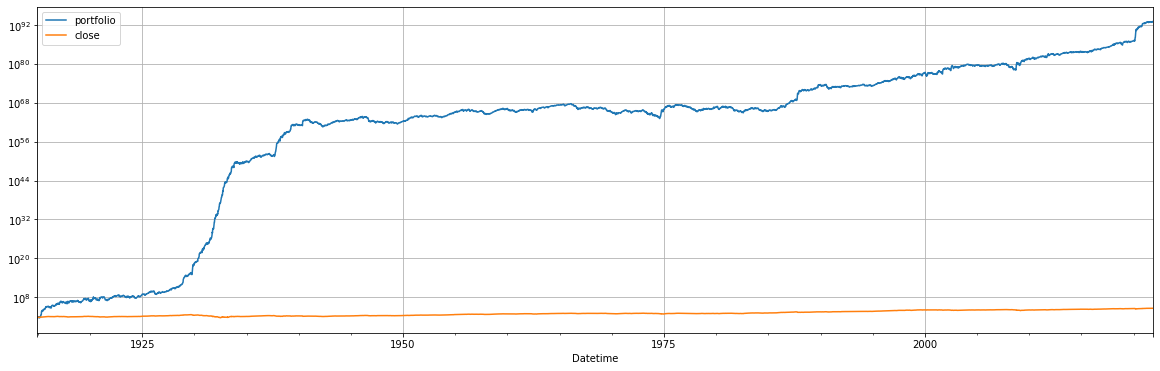

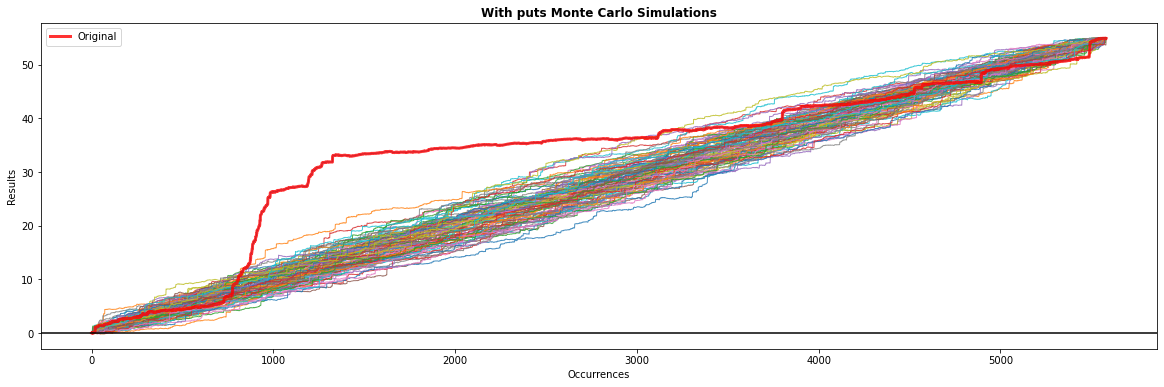

With puts Monte Carlo Simulations {'min': 54.88108366727829, 'max': 54.88108366727829, 'mean': 54.88108366727829, 'median': 54.88108366727829, 'std': 0.0, 'maxdd': -0.18082952499389648, 'bust': 0.0, 'goal': 1.0}


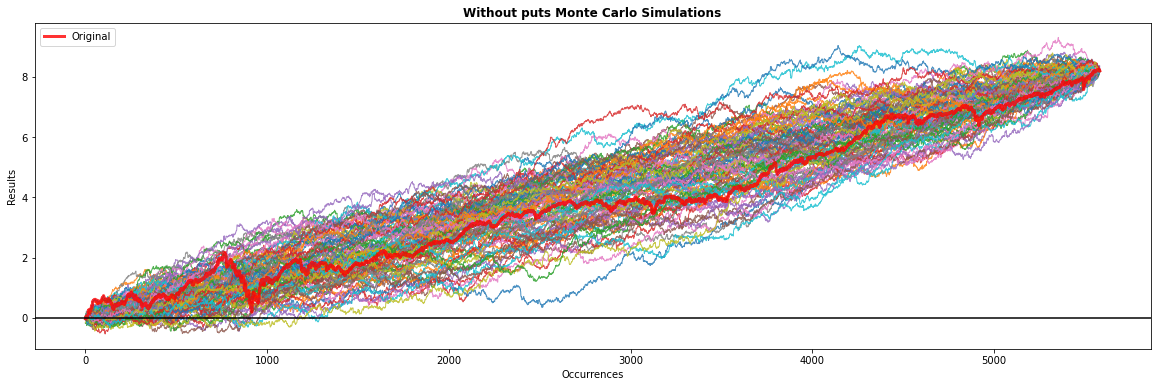

Without puts Monte Carlo Simulations {'min': 8.19879025220871, 'max': 8.19879025220871, 'mean': 8.19879025220871, 'median': 8.19879025220871, 'std': 0.0, 'maxdd': -0.5359482765197754, 'bust': 0.23, 'goal': 0.77}


In [347]:
# ATM put sold at premium AND 2sd bought
premiumGain = 0.085 / 100  # threshold at which bust is acceptable in montecarlo
premiumPay = .085 / 100
multiplier = 10

# TODO needs work
def gainPutsATMRatio(row, winThreshold):
    if -premiumGain > row["pct"] > -winThreshold:
        return premiumGain - premiumPay + row["pct"]
    elif row["pct"] <= -winThreshold:
        optionReturns = (
            premiumGain - premiumPay + (-row["pct"] - winThreshold) * multiplier
        )
        return optionReturns
    elif row["pct"] > 0:
        return premiumGain - premiumPay + row["pct"]
    elif -premiumGain < row["pct"] <= 0:
        optionReturns = premiumGain - premiumPay + row["pct"]
        print (premiumGain, premiumPay, row["pct"], winThreshold,
        optionReturns)
        return optionReturns
    elif np.isnan(row["pct"]):
        return 0
    else:
        raise NotImplementedError


doDf(weekly, costOfOptions=0, gainFn=gainPutsATMRatio, multiplier=multiplier,
winThreshold=5/100)
plot(weekly)
montecarlo(weekly, "With puts Monte Carlo Simulations", "gain_pct")
montecarlo(weekly, "Without puts Monte Carlo Simulations", "pct")


In [200]:
len(weekly[weekly["pct"] < 0.01]), len(weekly)

(3740, 5582)

In [134]:
stdev = weekly["pct"].std()
print(stdev)


0.025032688


In [153]:
twoweekly = df5["Value"].resample('2W').ohlc()
#print (twoweekly)
twoweekly["close"].pct_change().std()

0.035473306